# Task 1. Create a Scoring Scheme for Listed Houses

#### Methodology
    - Select Attributes that are mostly complete and generally describe a property hollistically
    - Some inspection shows simple imputation is fallible to outlier irregularities,
        - Lot of rows though non-empty likely has garbage values. eg: There are houses with structure tax 1,2,3 etc.
          similarly for lotsizes, finished square feet etc.
        - So it's a safe bet to reject all data in bottom and top 5%ile for each column.
        - This gets us clean data of 1.3million points.
    - The distributions of attributes are mostly skewed, so 
        - Get quantile scores for each columns, i.e - Each value gets a score between 0-1.
        - The columns with descending desirability get scores of the form (1 - quant. score) i.e higher is worse.
        - Now all columns are transformed to uniform(0,1) distributions.
        - We call these component scores of attributes for the listing
    - Score for each listed property is chosen to be a linear combination of the component attribute scores
        - I choose to combine using Principal Component 1 coefficients.
    -Finally we obtain a distribution of the scores for the data pool

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from collections import defaultdict

### Getting the data
    - We read the data
    -selecting Columns of interest
        - select some count data about the house, 
        - an oldness qualifier, 
        - a monetary qualifier, and 
        - house space-descriptors
    - Do some analysis on how much missing data exists
      - Given our choice of columns, not much. So we can safely discard the rows with NaNs
    

In [ ]:
df = pd.read_csv("C://Users//ibipul//codes//datasets//Zillow_data//train_2016_v2.csv")

In [ ]:
dfp = pd.read_csv("C://Users//ibipul//codes//datasets//Zillow_data/properties_2016.csv", low_memory = False)

In [122]:
# Picking the desirability attributes
desirability_attributes = []
key = ['parcelid']
count_attributes = ['bedroomcnt','bathroomcnt']
house_area_attributes = ['calculatedfinishedsquarefeet','lotsizesquarefeet']
oldness_attribute = ['yearbuilt']
monetary_attribute = ['structuretaxvaluedollarcnt']

desirability_attributes = count_attributes + house_area_attributes + oldness_attribute + monetary_attribute
all_attributes = key + desirability_attributes

In [123]:
dfr = dfp[all_attributes]

In [124]:
dfr[desirability_attributes].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
bedroomcnt,2973767.0,3.088949,1.275859,0.0,2.0,3.0,4.0,20.0
bathroomcnt,2973755.0,2.209143,1.077754,0.0,2.0,2.0,3.0,20.0
calculatedfinishedsquarefeet,2929652.0,1827.162124,1819.780469,1.0,1213.0,1572.0,2136.0,952576.0
lotsizesquarefeet,2709118.0,22822.805528,337592.366408,100.0,5688.0,7000.0,9898.0,328263808.0
yearbuilt,2925289.0,1964.261641,23.441319,1801.0,1950.0,1963.0,1981.0,2015.0
structuretaxvaluedollarcnt,2930235.0,170883.577166,402068.342015,1.0,74800.0,122590.0,196889.0,251486000.0


In [125]:
# Analysis of missing data
missing_df = dfr.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')
missing_df

,column_name,missing_count
1,bedroomcnt,11450
2,bathroomcnt,11462
6,structuretaxvaluedollarcnt,54982
3,calculatedfinishedsquarefeet,55565
5,yearbuilt,59928
4,lotsizesquarefeet,276099


In [126]:
# Drop all rows with NaNs
dfr1 = dfr.dropna(axis=0, how='any')

In [127]:
dfr1[all_attributes].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
parcelid,2688057.0,1.280385e+07,2.413644e+06,10711725.0,11578096.0,12425993.0,13934696.0,163275886.0
bedroomcnt,2688057.0,3.229671e+00,1.181220e+00,0.0,3.0,3.0,4.0,20.0
bathroomcnt,2688057.0,2.275778e+00,1.041868e+00,0.0,2.0,2.0,3.0,20.0
calculatedfinishedsquarefeet,2688057.0,1.861594e+03,1.625765e+03,1.0,1238.0,1604.0,2188.0,952576.0
lotsizesquarefeet,2688057.0,2.258375e+04,3.377145e+05,104.0,5694.0,7000.0,9873.0,328263808.0
yearbuilt,2688057.0,1.962227e+03,2.285559e+01,1801.0,1949.0,1961.0,1979.0,2015.0
structuretaxvaluedollarcnt,2688057.0,1.705272e+05,2.814063e+05,1.0,75180.0,122831.0,197150.0,109192169.0


### Cleaning the dataset
    - Based on the table above, simple imputations of min values in count data, structuretaxvalue, or finished sq feet data
      would not make a lot of sense as I observed there are a range of values which are not natural.
      - For instance structure tax values are present like 1,2,3,4... again more than millions etc
        While practically higher values may make sense, as compared to lower values, 
        but I'd like to build on a standard range.
    -So my cleaning scheme:
        - reject data points for each column which are below 5%ile of the values.
        - reject data points for each column where data points are above 95% of values

In [128]:
# Imputations don't make much sense here, as there are a range of values for which we might have junk numbers
# Like some inspection showed there are cases where rooms are listed to have calculated finished sq foot of 1, or 
# structural tax of of 1 dollar. Often lot size, structural tax have ridiculously high values.
# So I intend to drop bottom 5%ile and top 95%ile data to get rid of outliers rather than taking up
# a hackneyed imputation
count_cols = ['bedroomcnt','bathroomcnt']
filter_by_percentile_cols = ['calculatedfinishedsquarefeet','lotsizesquarefeet', 'structuretaxvaluedollarcnt'] + count_cols

In [129]:
## Removal band specifies how much data we are rejecting from either end
removal_band = 5
quanitile_filter_dict = defaultdict()
for col in filter_by_percentile_cols:
    quanitile_filter_dict[col] = (np.percentile(dfr1[col],removal_band),np.percentile(dfr1[col],100 - removal_band))

In [130]:
dfr2 = dfr1.copy()
for key in quanitile_filter_dict.keys():
    print('Column: ', key,' Drop below: ', quanitile_filter_dict[key][0],' Drop Above: ', quanitile_filter_dict[key][1])
    dfr2 = dfr2[dfr2[key] > quanitile_filter_dict[key][0]]
    dfr2 = dfr2[dfr2[key] < quanitile_filter_dict[key][1]]

Column:  calculatedfinishedsquarefeet  Drop below:  860.0  Drop Above:  3583.0
Column:  lotsizesquarefeet  Drop below:  3200.0  Drop Above:  75658.0
Column:  structuretaxvaluedollarcnt  Drop below:  31392.0  Drop Above:  432375.2
Column:  bedroomcnt  Drop below:  2.0  Drop Above:  5.0
Column:  bathroomcnt  Drop below:  1.0  Drop Above:  4.0


In [131]:
# Clearly data looks much more sensible now, how ever our current data set is now 1.36 million points
dfr2[all_attributes].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
parcelid,1360701.0,1.300694e+07,2.554090e+06,10711725.0,11556686.0,12696274.0,14077908.0,163275886.0
bedroomcnt,1360701.0,3.422096e+00,4.938938e-01,3.0,3.0,3.0,4.0,4.0
bathroomcnt,1360701.0,2.323959e+00,4.634935e-01,1.5,2.0,2.0,3.0,3.5
calculatedfinishedsquarefeet,1360701.0,1.806830e+03,5.057303e+02,861.0,1420.0,1703.0,2108.0,3582.0
lotsizesquarefeet,1360701.0,8.887701e+03,7.449588e+03,3201.0,5985.0,7000.0,8650.0,75642.0
yearbuilt,1360701.0,1.964505e+03,1.952145e+01,1810.0,1954.0,1962.0,1978.0,2015.0
structuretaxvaluedollarcnt,1360701.0,1.469807e+05,8.090506e+04,31393.0,86000.0,129658.0,190205.0,432372.0


### Desirablity:
    - More Bedrooms & bath rooms more desirable, higher scores better
    - More finished square footing and more lot area means more desirable, higher scores will mean better
    - Buildings built later implies newer buildings, hence more desirable, higher score better
    - Lower tax value means higher desirability, Lower scores will mean better

In [132]:
from scipy import stats

In [133]:
ascending_desirability_columns = ['bedroomcnt','bathroomcnt','calculatedfinishedsquarefeet','lotsizesquarefeet', 'yearbuilt']
descending_desirability_columns = ['structuretaxvaluedollarcnt']
quantile_score_columns = ascending_desirability_columns + descending_desirability_columns
parcel_ids = pd.DataFrame(dfr2['parcelid'])


In [134]:
#Creating the data frame with Quantile scores of the data
# This also removes the need to normalise columns, as the data is now mapped to 0-1 range, for all
quantile_score_frame = pd.DataFrame({'structuretaxvaluedollarcnt_score': 1 - (stats.rankdata(dfr2['structuretaxvaluedollarcnt'], 
                                                                     "average")/len(dfr2['structuretaxvaluedollarcnt']))})
score_names = ['structuretaxvaluedollarcnt_score']
for col in ascending_desirability_columns:
    quantile_score_frame[col+'_score'] = stats.rankdata(dfr2[col], "average")/len(dfr2[col])
    score_names += [col + '_score']

quantile_score_frame['parcelid'] = parcel_ids.iloc[:,0].values

In [135]:
all_score_columns = score_names + ['parcelid']

In [136]:
dfr2.head(5)

,parcelid,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,lotsizesquarefeet,yearbuilt,structuretaxvaluedollarcnt
31,11585547,3.0,2.0,2077.0,6490.0,1926.0,207035.0
43,11759947,4.0,2.0,1931.0,5420.0,1957.0,122915.0
101,12606547,3.0,3.0,2166.0,22073.0,2005.0,363000.0
109,12757147,3.0,2.0,1300.0,4917.0,1950.0,76253.0
110,12757947,3.0,2.0,1222.0,5500.0,1951.0,116069.0


In [137]:
quantile_score_frame[all_score_columns].head(5)
# We can see how the quantile scores are behaving as we set up the desirability definitions

,structuretaxvaluedollarcnt_score,bedroomcnt_score,bathroomcnt_score,calculatedfinishedsquarefeet_score,lotsizesquarefeet_score,yearbuilt_score,parcelid
0,0.203687,0.288953,0.323210,0.735119,0.395742,0.041892,11585547
1,0.535923,0.788953,0.323210,0.656840,0.164248,0.375079,11759947
2,0.019898,0.288953,0.852832,0.775931,0.959389,0.984010,12606547
3,0.805760,0.288953,0.323210,0.148551,0.075224,0.171228,12757147
4,0.573477,0.288953,0.323210,0.087150,0.176444,0.191573,12757947


### Generating combination Linear combination coifficients using PCA

In [138]:
X = quantile_score_frame[score_names]
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [139]:
combination_coefficients = pd.DataFrame(pca.components_[0]) 
# Eigen Vector of PC1. nx1 form
combination_coefficients

,0
0,-0.520797
1,0.235099
2,0.430328
3,0.546572
4,0.172876
5,0.399611


### Generating the desirability Score for the houses

In [142]:
#Linear Combination of score columns with the PC1 coefficients. nx6 mult 6x1 = nx1 score values.
desirability_score = np.dot(quantile_score_frame[score_names], combination_coefficients)
quantile_score_frame['desirability_score'] = desirability_score

## Score Distribution 
    - Following is the distribution of scores we have assigned to the houses
    - Now We can sort the houses by these scores and 
        -the top 10 will have highest scores 
        - the bottom 10 will have the lowest scores
        
### All the houses have been mapped to score values between (-0.5, 1.8)
#### Higher score implies a higher desirability of a house than a house with a lower score
    - On the X axis we have the scores
    - On the Y axis we have the frequency
    - According to our scoring algorithm
      - largest number of houses have scores between 0-0.25

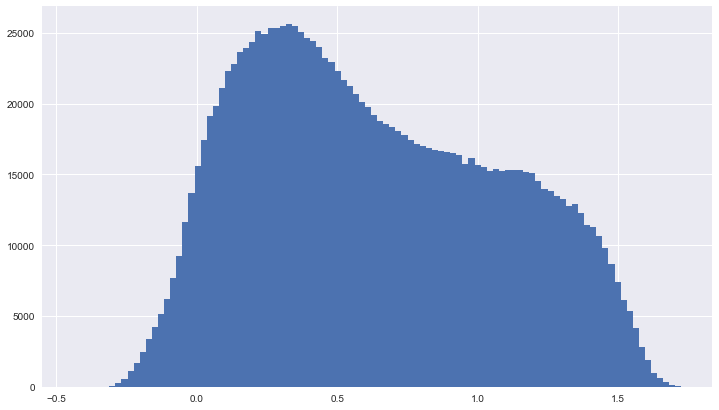

In [148]:
fig = plt.figure(figsize=(12,7))
x=plt.hist(quantile_score_frame['desirability_score'],bins=100)

### Top 10 Houses
These are the 10 houses ranked by the desirability score

In [146]:
quantile_score_frame.nlargest(10, 'desirability_score')

,structuretaxvaluedollarcnt_score,bedroomcnt_score,bathroomcnt_score,calculatedfinishedsquarefeet_score,lotsizesquarefeet_score,yearbuilt_score,parcelid,desirability_score
209387,0.002664,0.788953,0.996159,0.996772,0.978609,0.996314,14202712,1.724894
782015,0.007261,0.788953,0.996159,0.997825,0.963362,0.997624,17257315,1.720963
876111,0.001374,0.788953,0.996159,0.994658,0.955507,0.984010,14145142,1.715499
1177315,0.001056,0.788953,0.996159,0.993698,0.993605,0.967803,17300511,1.715250
393266,0.004982,0.788953,0.996159,0.983406,0.963675,0.997004,14201457,1.714075
508981,0.001559,0.788953,0.996159,0.996587,0.986777,0.962090,14232873,1.713104
1027010,0.010693,0.788953,0.996159,0.993676,0.972135,0.984010,17051508,1.712984
1331984,0.008381,0.788953,0.996159,0.998878,0.962523,0.973224,14144920,1.711059
577720,0.003893,0.788953,0.996159,0.995828,0.994223,0.956012,17264250,1.710331
659367,0.003450,0.788953,0.996159,0.998077,0.943581,0.973224,17263523,1.709915


### Bottom 10 houses
These are the bottom 10 houses ranked by the desirability score

In [147]:
quantile_score_frame.nsmallest(10, 'desirability_score')

,structuretaxvaluedollarcnt_score,bedroomcnt_score,bathroomcnt_score,calculatedfinishedsquarefeet_score,lotsizesquarefeet_score,yearbuilt_score,parcelid,desirability_score
515493,0.990136,0.288953,0.006787,0.002211,0.015235,0.001365,14132206,-0.440420
1129310,0.961495,0.288953,0.006787,0.004681,0.018869,0.005261,17066219,-0.421968
748124,0.980024,0.288953,0.006787,0.007135,0.025849,0.036680,17097563,-0.416515
461828,0.954598,0.288953,0.006787,0.000223,0.041751,0.062132,14404129,-0.394131
235708,0.986342,0.288953,0.006787,0.067440,0.033187,0.046515,13878336,-0.381646
1079579,0.994777,0.288953,0.006787,0.003160,0.011565,0.171228,13893976,-0.375073
924999,0.933541,0.288953,0.006787,0.000149,0.208086,0.050470,17070566,-0.359110
971268,0.970329,0.288953,0.006787,0.037594,0.350226,0.003637,14118787,-0.351945
235637,0.989538,0.288953,0.006787,0.021173,0.350226,0.054022,13839592,-0.350790
1025246,0.989829,0.288953,0.006787,0.000085,0.486024,0.024701,13951584,-0.350709


# Task 2. Choosing a Distance metric
    - This task requires us to figure out a distance metric between properties
    - The features should have:
        - property specific variables-- bathroom, bedroom counts, finished living area, year built, and structure tax.
        - location specific data: Latitude and longitude
### The Distance metric I am choosing is Mahalanobis distance
    - This is an improvement over the Eucleadian distance, as Eucledian distance gives equal importance to all features
    - Mahalanobis distance uses the covariance matrix of the data to normalise them
    
### Evaluation Process
    - Group A: 3 of the top 10 houses were chosen from the top 10 houses list of Task 1,
        - that were built around the same time 2000's, 
        - taxes close to eachother,
        - similar home configurations
        - similar square footage of living area
    - Group B: 3 of the bottom 10 houses were chosen from bottom 10 houses of of Task 1.
        which were much older, and had similar properties as described above.
        
    - A pairwise distance evaluation was run on the two groups stacked together.
    
### Results
    - Houses in group A had similar small distance among eachother (<1)
    - Houses in group B had small distance among eachother
    - Group A house to Group B house distance was >= 3

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [101]:
from collections import defaultdict

In [ ]:
df = pd.read_csv("C://Users//ibipul//codes//datasets//Zillow_data//train_2016_v2.csv")

In [ ]:
dfp = pd.read_csv("C://Users//ibipul//codes//datasets//Zillow_data/properties_2016.csv", low_memory = False)

### Choice of attributes
    - Attributes chosen are similar as Task 1, 
    - Only latitude and longitude are being added to bring in the geographical favour

In [100]:
distance_attributes = []
key = ['parcelid']
latlong = ['latitude', 'longitude']
count_attributes = ['bedroomcnt','bathroomcnt']
house_area_attributes = ['calculatedfinishedsquarefeet']
oldness_attribute = ['yearbuilt']
monetary_attribute = ['structuretaxvaluedollarcnt']
distance_attributes = latlong + count_attributes + house_area_attributes + oldness_attribute + monetary_attribute
all_attributes = key + distance_attributes

In [102]:
dfr = dfp[all_attributes]

In [103]:
## Testing out the missing data stats
missing_df = dfr.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')
missing_df

,column_name,missing_count
1,latitude,11437
2,longitude,11437
3,bedroomcnt,11450
4,bathroomcnt,11462
7,structuretaxvaluedollarcnt,54982
5,calculatedfinishedsquarefeet,55565
6,yearbuilt,59928


In [104]:
## It suffices to just drop the NaNs 
#as we will just be testing out the distance in a controlled manner in this example.
dfr = dfr.dropna(how='any',axis=0)

In [105]:
dfr[distance_attributes].head()

,latitude,longitude,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,yearbuilt,structuretaxvaluedollarcnt
3,34148863.0,-118437206.0,0.0,0.0,5068.0,1948.0,571346.0
4,34194168.0,-118385816.0,0.0,0.0,1776.0,1947.0,193796.0
5,34171873.0,-118380906.0,0.0,0.0,2400.0,1943.0,176383.0
7,34171345.0,-118314900.0,0.0,0.0,3611.0,1946.0,101998.0
9,34289776.0,-118432085.0,0.0,0.0,3754.0,1978.0,218440.0


### Distance metric
    - Here we set up the mahalanobis distance metric using sklearn
    - The covariance matrix of data has to be computed and passed to the
    get_metric() function as a parameter.

In [110]:
from sklearn.neighbors import DistanceMetric

In [109]:
## Getting the covariance matrix
V=np.cov(dfr[distance_attributes].T)
V

array([[  5.86461153e+10,  -4.82392648e+10,   9.31523517e+03,
          3.57923331e+03,  -5.48357979e+05,  -6.42482701e+04,
          8.76025720e+07],
       [ -4.82392648e+10,   1.17725406e+11,   4.18600570e+03,
         -3.20486989e+03,  -6.50499067e+06,   5.12519113e+05,
         -4.24304022e+09],
       [  9.31523517e+03,   4.18600570e+03,   1.40799919e+00,
          8.03598938e-01,   5.69965726e+02,   1.97101711e+00,
          6.47479144e+04],
       [  3.57923331e+03,  -3.20486989e+03,   8.03598938e-01,
          1.05903059e+00,   6.66080529e+02,   8.59484629e+00,
          1.17718192e+05],
       [ -5.48357979e+05,  -6.50499067e+06,   5.69965726e+02,
          6.66080529e+02,   3.27077151e+06,   5.03292533e+03,
          3.97151210e+08],
       [ -6.42482701e+04,   5.12519113e+05,   1.97101711e+00,
          8.59484629e+00,   5.03292533e+03,   5.48738320e+02,
          1.51187923e+06],
       [  8.76025720e+07,  -4.24304022e+09,   6.47479144e+04,
          1.17718192e+05,   3.97

In [111]:
dist_m = DistanceMetric.get_metric('mahalanobis', V=np.cov(dfr[distance_attributes].T))

### Evaluation
    - First we get the list of top 10 and bottom 10 houses we obtained in previous task
    - We acquire corresponding subsets

In [114]:
top_10_house_ids = [14202712,17257315,14145142,17300511,14201457,14232873,17051508,14144920,17264250,17263523]
bottom_10_house_ids = [14132206,17066219,17097563,14404129,13878336,13893976,17070566,14118787,13839592,13951584]

In [115]:
# These are the top 10 and bottom 10 houses as obtained from Scoring developed earlier
top_10_houses = dfr[dfr['parcelid'].isin(top_10_house_ids)]
bottom_10_houses = dfr[dfr['parcelid'].isin(bottom_10_house_ids)]

    - Top 3 houses of top 10 houses &
    - Bottom 3 houses of bottom 10 houses are chosen for the test

In [116]:
from sklearn.metrics.pairwise import pairwise_distances

In [118]:
house_mix = top_10_houses[:3].append(bottom_10_houses[7:10])
house_mix

,parcelid,latitude,longitude,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,yearbuilt,structuretaxvaluedollarcnt
457881,14202712,33895303.0,-117730832.0,4.0,3.5,3431.0,2009.0,418848.0
859514,14201457,33878347.0,-117716104.0,4.0,3.5,3133.0,2010.0,408255.0
1112356,14232873,33797701.0,-117781094.0,4.0,3.5,3422.0,2001.0,424425.0
2241462,13951584,33771991.0,-117951852.0,3.0,1.5,876.0,1923.0,34871.0
2360062,13893976,33594772.0,-117869225.0,3.0,1.5,999.0,1950.0,33372.0
2468660,17066219,34400333.0,-118911182.0,3.0,1.5,1014.0,1910.0,43077.0


In [119]:
pd.DataFrame(dist_m.pairwise(house_mix[distance_attributes]))

,0,1,2,3,4,5
0,0.000000,0.213766,0.706355,3.973377,3.363108,5.380226
1,0.213766,0.000000,0.714472,3.965588,3.328405,5.416363
2,0.706355,0.714472,0.000000,3.557867,2.874884,5.112261
3,3.973377,3.965588,3.557867,0.000000,1.507543,3.073966
4,3.363108,3.328405,2.874884,1.507543,0.000000,3.989124
5,5.380226,5.416363,5.112261,3.073966,3.989124,0.000000


### Result:
    -- We can clearly see, houses 0,1,2 which are among the top 3 houses and similar in listing and also locally closer
       have very low inter point distance.
    -- Compared to them houses 3,4,5 which are essentially bottom 3 houses of bottom 10 houses and have a much difference
       in listing descriptions are quite far away from group of houses {0,1,2}.
    -- Interestingly, even intra-group distance among bottom 3 houses is higher as they were built over 50 years of time.

### Experimental figure 
### (Using sns.heatmap as a hack to visualise & illustrate the pairwise distance matrix)
Below I have tried to elucidate the above point with a figure. Passed the computed distance matrix to the heatmap visualization function, which essentially takes a square matrix and plots the intensities of the values in each cell.

    - We can see that houses 0,1,2 have values very similar among eachother compared to 
      set of houses 3,4,5
    - also color among houses in 3,4,5 is not as uniform as in the other group owing to the in group 
      dissimilarity of the houses as well (as discussed above)

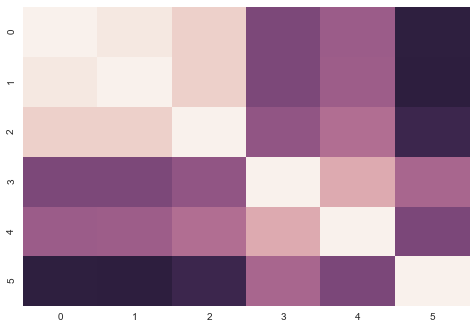

In [120]:
sns.heatmap(pd.DataFrame(dist_m.pairwise(house_mix[distance_attributes])),cbar=False)

# Task 3. Clustering with the proposed distance function

Here we try an unsupervisied clustering using the distance metric that was proposed in task 2.
    - We use DBSCAN algorithm, with parameters set to epsilon 0.5 and min_samples 40.
    - Distance metric is chosesn as mahalanobis distance, with the covariance matrix generated from Data
      - Added benefit of this is we do not need to run a separate normalization, as this distance is
        itself a form of normalized euclidean distance.
    - We use 60k zillow data points for this task.
    - 36 Clusters were obtained, along with a cluster tagged -1, which is composed of samples which are 
      noisy and could not be clustered. 
    - A dot-plot of the analysis is presented (with noisy points removed)

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

In [91]:
from sklearn.neighbors import DistanceMetric
from sklearn.cluster import DBSCAN

In [80]:
from matplotlib.pyplot import cm 

In [81]:
df = pd.read_csv("C://Users//ibipul//codes//datasets//Zillow_data//train_2016_v2.csv")

In [82]:
dfp = pd.read_csv("C://Users//ibipul//codes//datasets//Zillow_data/properties_2016.csv", low_memory = False)

In [83]:
distance_attributes = []
key = ['parcelid']
latlong = ['latitude', 'longitude']
count_attributes = ['bedroomcnt','bathroomcnt']
house_area_attributes = ['calculatedfinishedsquarefeet']
oldness_attribute = ['yearbuilt']
monetary_attribute = ['structuretaxvaluedollarcnt']
distance_attributes = latlong + count_attributes + house_area_attributes + oldness_attribute + monetary_attribute
all_attributes = key + distance_attributes

In [84]:
dfr = dfp[all_attributes]

In [85]:
## Testing out the missing data stats
missing_df = dfr.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')
missing_df

,column_name,missing_count
1,latitude,11437
2,longitude,11437
3,bedroomcnt,11450
4,bathroomcnt,11462
7,structuretaxvaluedollarcnt,54982
5,calculatedfinishedsquarefeet,55565
6,yearbuilt,59928


In [86]:
## It suffices to just drop the NaNs 
#as we will just be testing out the distance in a controlled manner in this example.
dfr = dfr.dropna(how='any',axis=0)

In [87]:
# reverting lat longs in their usual forms
dfr.latitude = dfr.latitude/10**6
dfr.longitude = dfr.longitude/10**6

In [88]:
dfr[distance_attributes].head()

,latitude,longitude,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,yearbuilt,structuretaxvaluedollarcnt
3,34.148863,-118.437206,0.0,0.0,5068.0,1948.0,571346.0
4,34.194168,-118.385816,0.0,0.0,1776.0,1947.0,193796.0
5,34.171873,-118.380906,0.0,0.0,2400.0,1943.0,176383.0
7,34.171345,-118.314900,0.0,0.0,3611.0,1946.0,101998.0
9,34.289776,-118.432085,0.0,0.0,3754.0,1978.0,218440.0


### Clustering Step

    - First we get the covariance matrix of this data (7x7)
    - Next we set up the DBSCAN clustering object with metric mahalanobis, and param cov matrix of data.
    - We set the algorithm to be used for clustering to be ball_tree
    - The process is run on 60k points
#### Results:
    - 36 unique clusters are obtained, additionally a noise cluster tagged -1 is returned.
    - A dot plot is made with the lat-long features in the data. 

In [89]:
cov_data=np.cov(dfr[distance_attributes].T)

In [92]:
# Creating the DBSCAN Clustering Object
db = DBSCAN(eps=0.5, min_samples =40, metric='mahalanobis',metric_params={'V': cov_data},n_jobs=-1, algorithm='ball_tree')

In [94]:
# The actual clustering step with the DBSCAN object
db.fit(dfr[distance_attributes][:60000])

DBSCAN(algorithm='ball_tree', eps=0.5, leaf_size=30, metric='mahalanobis',
    metric_params={'V': array([[  5.86461e-02,  -4.82393e-02,   9.31524e-03,   3.57923e-03,
         -5.48358e-01,  -6.42483e-02,   8.76026e+01],
       [ -4.82393e-02,   1.17725e-01,   4.18601e-03,  -3.20487e-03,
         -6.50499e+00,   5.12519e-01,  -4.24304e+03],
       [  9.31524e-03,   4.18601e-03... -4.24304e+03,   6.47479e+04,   1.17718e+05,
          3.97151e+08,   1.51188e+06,   1.21867e+11]])},
    min_samples=40, n_jobs=-1, p=None)

In [95]:
print('Estimated number of clusters: %d' % len(set(db.labels_)))

Estimated number of clusters: 37


In [96]:
cl_data = dfr[distance_attributes][:60000]
cl_data['label'] = db.labels_

In [97]:
cl_data.label.unique()

array([-1, 32,  2,  0, 12,  1,  3,  4,  5,  7,  8, 35,  6, 11,  9, 10, 13,
       14, 15, 16, 17, 18, 21, 33, 20, 19, 23, 22, 27, 30, 28, 29, 24, 25,
       34, 31, 26], dtype=int64)

In [98]:
groups = cl_data.groupby('label')

We use YlGn Color palatter of matplotlib to generate the desired dot plot.
    - In this plot area the Coastline that extends from Long beach (centre) to San Diego below.
    - The small disjointed location far from the coastline is probably the area around Palm Springs

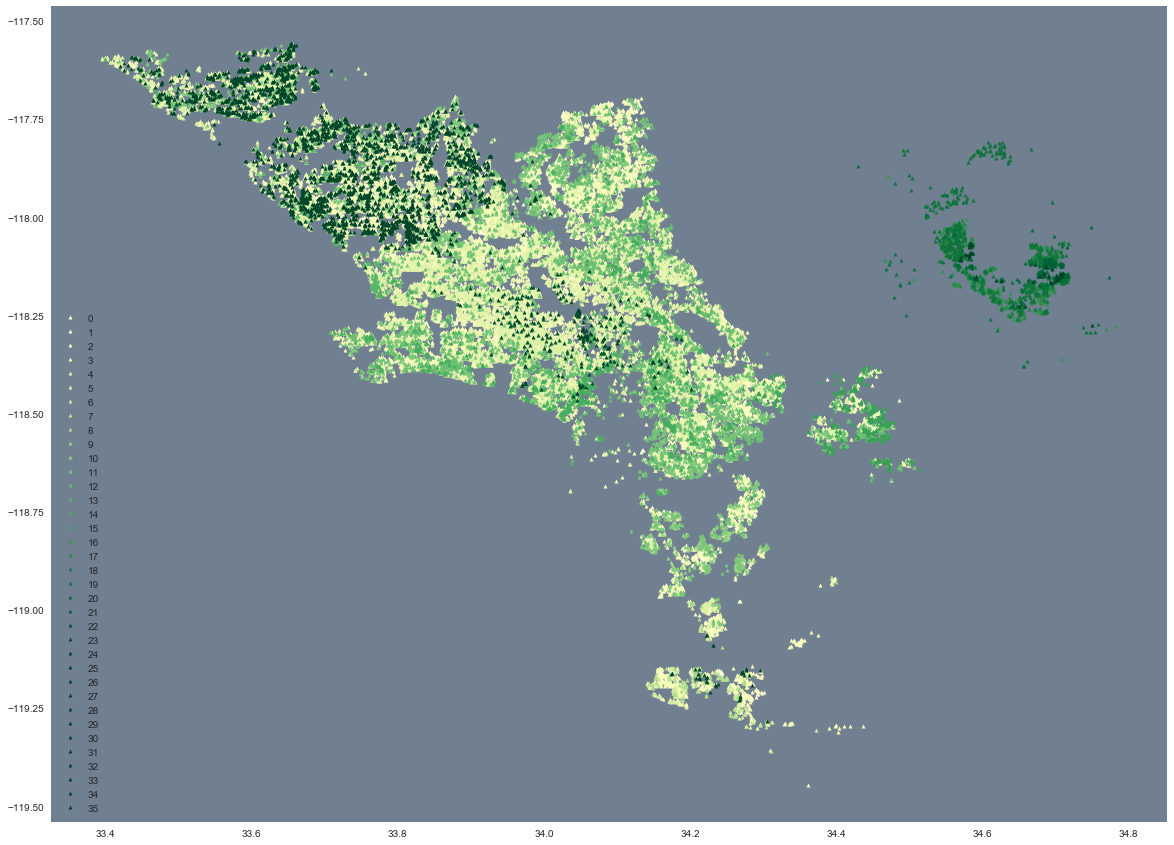

In [157]:
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111,facecolor='slategrey')
color=iter(cm.YlGn(np.linspace(0,3,2*len(cl_data.label.unique()))))
#c=next(color)
ax.margins(0.05)
ax.grid(False)
for name, group in groups:
    c=next(color)
    lats = group.latitude
    lons = group.longitude
    if name == -1:
          # Filtering out the Noise (aka points that couldn't be clustered)
        continue
    else:
        ax.plot(lats, lons, marker='^', ms=4, linestyle='', label=name, color=c)
    
ax.legend()

# Task 4. Select an external dataset that may enhance the existing dataset

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from collections import defaultdict

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

#### External Data gathering
Here are my external data sources, they are publicly available:
    - http://www.usinflationcalculator.com/inflation/current-inflation-rates/
      I have obtained the month on month inflation rates from here.
    - https://www.reit.com/data-research/reit-indexes/monthly-property-index-values-returns
      This is called Real Estate Investment Trust. It tracks several indices about real estate and it's specific contributing
      factors. I have used the month on month % change in prices from the indices.
      
#### What is a 'Real Estate Investment Trust - REIT'

A REIT is a type of security that invests in real estate through property or mortgages and often trades on major exchanges like a stock. REITs provide investors with an extremely liquid stake in real estate. They receive special tax considerations and typically offer high dividend yields.

REITs, an investment vehicle for real estate that is comparable to a mutual fund, allowing both small and large investors to acquire ownership in real estate ventures, own and in some cases operate commercial properties such as apartment complexes, hospitals, office buildings, timber land, warehouses, hotels and shopping malls.

All REITs must have at least 100 shareholders, no five of whom can hold more than 50% of shares between them. At least 75% of a REIT's assets must be invested in real estate, cash or U.S. Treasurys; 75% of gross income must be derived from real estate.

REITs are required by law to maintain dividend payout ratios of at least 90%, making them a favorite for income-seeking investors. REITs can deduct these dividends and avoid most or all tax liabilities, though investors still pay income tax on the payouts they receive. Many REITs have dividend reinvestment plans (DRIPs​), allowing returns to compound over time.


Source: Real Estate Investment Trust (REIT) http://www.investopedia.com/terms/r/reit.asp#ixzz4vZIsSkR8 
    

In [ ]:
year_month = [201601,201602,201603,201604,201605,201606,201607,201608,201609,201610,201611,201612,
         201701,201702,201703,201704,201705,201706,201707,201708,201709]

In [ ]:
# Inflation data
inflation_rate = [
     1.4,1.0,0.9,1.1,1.0,1.0,0.8,1.1,1.5,1.6,1.7,2.1,2.5,2.7,2.4,2.2,1.9,1.6,1.7,1.9,2.2]

In [ ]:
# Reit indices
equity_residential_index_price = [
    -5.01,-1.62,11.02,-6.42,3.96,2.93,1.93,-4.25,0.68,-2.81,-3.03,6.47,-2.42,5.16,-1.90,2.37,1.56,1.19,1.73,-0.07,-3.01]

In [ ]:
# Apartment pricing index
equity_apartments_index_price = [
    -5.09,-2.01,11.53,-6.73,3.41,1.94,1.58,-4.42,0.90,-2.97,-2.90,7.13,-3.42,4.86,-1.81,2.26,1.53,1.04,1.84,-0.43,-2.87 ]

In [ ]:
# healthcare pricing index
equity_healthcare_index_price = [
    -4.69,-2.17,9.62,0.07,1.61,8.69,5.69,-1.65,-2.50,-7.01,-8.67,4.22,0.23,6.02,-0.73,0.26,0.58,2.94,-2.59,-0.62,-3.48 ]

In [ ]:
# Single family home & manufactured home pricing index
equity_single_family_home_price_index = [
    -9.20,-3.87,12.70,-0.89,13.92,11.37,6.38,-0.32,-2.98,-1.90,1.35,-1.71,6.14,7.93,-1.73,0.65,-1.52,0.40,1.29,1.51,-2.45 ]
equity_manufactured_homes_price_index = [
    -1.99,4.18,4.67,-5.47,5.19,9.50,3.13,-4.70,0.83,-1.75,-7.02,5.22,2.49,6.33,-2.94,4.60,3.73,1.98,1.16,1.60,-4.74 ]

In [ ]:
## Mortgage
home_financing_price_index=[
    -4.29,5.19,3.46,1.28,3.96,2.60,1.51,0.21,-1.73,-0.73,1.72,-1.58,1.57,6.29,1.28,3.88,-1.12,0.24,0.81,1.82,-0.57 ]
infrastructure_reit_price_index = [
    -1.51,-1.18,6.67,1.74,2.54,9.40,-0.28,-1.99,-0.23,0.03,-10.92,3.54,-0.55,9.00,3.03,2.83,5.29,-0.38,2.14,7.45,-7.81 ]

In [4]:
## Finally Storing it up as a data set indexed by yearmonth (yyyymm)
indices_and_inflation_data = pd.DataFrame({'year_month':year_month,
                                'inflation_rate':inflation_rate,
                                'equity_residential_index_price':equity_residential_index_price,
                                'equity_apartments_index_price':equity_apartments_index_price,
                                'equity_healthcare_index_price':equity_healthcare_index_price,
                                'equity_single_family_home_price_index':equity_single_family_home_price_index,
                                'equity_manufactured_homes_price_index':equity_manufactured_homes_price_index,           
                                'home_financing_price_index':home_financing_price_index,
                                'infrastructure_reit_price_index':infrastructure_reit_price_index})
# Setting up addressable column names
pricing_column_names = ['home_financing_price_index','infrastructure_reit_price_index',# ]#,
                         'equity_residential_index_price','equity_single_family_home_price_index',
                        'equity_apartments_index_price']
inflation_rate_column_names = ['inflation_rate']
year_month_column_names = ['year_month']

### Correlation among the pricing indices, and inflation data
It makes sense to see how the month on month data on the various % change of indices correlate among eachother

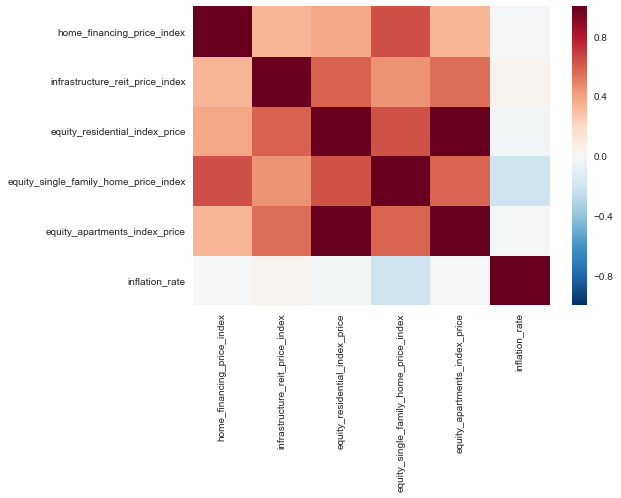

In [77]:
df_corr = indices_and_inflation_data[pricing_column_names+inflation_rate_column_names].corr()
sns.heatmap(df_corr,xticklabels=df_corr.columns.values,yticklabels=df_corr.columns.values)

It is interesting to see that there is some good correlation among the various index and pricing data that was obtained.
However it is also interesting to note, inflation rate almost 0 to inversely correlated with other indices in the pallatte.

It is however interesting to see that only inflation rates have a very minor correlation with log-error values (0.02). May be inflation rate can be useful when used in presense of the structure tax with some adjustment as well ass other details of the house. I present the correlation matrix below.

# Task 5. Building a Predictive model with esisting as well as external data
Here we use the external data set and learnings we obtained while performing previous tasks to create an improved model 
for the data set. 
    - First step is to train a model using the complete data we have for the two sets of zillow data.
    - Second we use that to predict costs for the time points in the sample submission data set.

#### Setting up the data
    - Read: train_2016, train_2017, properties_2016, properties_2017
    - join train and properties for 2016, and similarly for 2017 on parcelid columns
    - append the two joined data sets.
    - create the year_month colum for this data set
    - join this data set with the indices_and_inflation_data data set to add external data

In [5]:
df1 = pd.read_csv("C://Users//ibipul//codes//datasets//Zillow_data//train_2016_v2.csv")
df2 = pd.read_csv("C://Users//ibipul//codes//datasets//Zillow_data/train_2017.csv")

In [6]:
dfp1 = pd.read_csv("C://Users//ibipul//codes//datasets//Zillow_data/properties_2016.csv", low_memory = False)

In [7]:
dfp2 = pd.read_csv("C://Users//ibipul//codes//datasets//Zillow_data/properties_2017.csv", low_memory = False)

In [8]:
d1 = pd.merge(df1,dfp1, on='parcelid')

In [9]:
d2 = pd.merge(df2,dfp2, on='parcelid')

In [10]:
data = d1.append(d2, ignore_index=True)

#### Functions to split up month year

In [11]:
#Convert transaction date to yearmonth format
def yearmonth(x):
    s = x.split('-')
    return int(s[0]+s[1])
def getmonth(x):
    s = x.split('-')
    return int(s[1])
def getyear(x):
    s = x.split('-')
    return int(s[0])

data['year_month'] = data.transactiondate.apply(lambda x: yearmonth(x)) 
data['month'] = data.transactiondate.apply(lambda x: getmonth(x))
data['year'] = data.transactiondate.apply(lambda x: getyear(x))

In [12]:
data = pd.merge(data,indices_and_inflation_data, on='year_month')

In [13]:
data.head()

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,month,year,equity_apartments_index_price,equity_healthcare_index_price,equity_manufactured_homes_price_index,equity_residential_index_price,equity_single_family_home_price_index,home_financing_price_index,inflation_rate,infrastructure_reit_price_index
0,11016594,0.0276,2016-01-01,1.0,NaN,NaN,2.0,3.0,NaN,4.0,...,1,2016,-5.09,-4.69,-1.99,-5.01,-9.2,-4.29,1.4,-1.51
1,14366692,-0.1684,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,1,2016,-5.09,-4.69,-1.99,-5.01,-9.2,-4.29,1.4,-1.51
2,12098116,-0.0040,2016-01-01,1.0,NaN,NaN,3.0,2.0,NaN,4.0,...,1,2016,-5.09,-4.69,-1.99,-5.01,-9.2,-4.29,1.4,-1.51
3,12643413,0.0218,2016-01-02,1.0,NaN,NaN,2.0,2.0,NaN,4.0,...,1,2016,-5.09,-4.69,-1.99,-5.01,-9.2,-4.29,1.4,-1.51
4,14432541,-0.0050,2016-01-02,NaN,NaN,NaN,2.5,4.0,NaN,NaN,...,1,2016,-5.09,-4.69,-1.99,-5.01,-9.2,-4.29,1.4,-1.51


### Data Preprocessing
- Here we select some of the desirable columns for out predictions
- Then we clean up the missing values, remove outliers ans do necessary data imputations.
- Data is categorised as: 
    - initial numeric data from existing data,
    - additional numeric data from external source
    - categorical (from existing source)
    - Oldness attribute
  All these comprise the properties variables of interest

In [15]:
# Categorical variables are Numeric here. Replace NaN's with 0.0, then hot one encode.
categorical_variables=['buildingqualitytypeid','heatingorsystemtypeid', 'year','month']
oldness_attribute = ['yearbuilt']
## Impute the NaN's in the following columns with median values
initial_numeric_variables = ['bathroomcnt','bedroomcnt','calculatedfinishedsquarefeet','structuretaxvaluedollarcnt'] + oldness_attribute
additional_numeric_variables = pricing_column_names + inflation_rate_column_names

numeric_variables = initial_numeric_variables + additional_numeric_variables
# This is the key variable that will help with the join
key_variable = ['parcelid']
log_error_variable = ['logerror']
# Full variable list:
properties_variables = key_variable + log_error_variable + numeric_variables + categorical_variables

In [17]:
# Data subsetting
d = data[properties_variables]

Following is a heatmap plot of all the variables that I am about to use in this modelling exercise.
    - The external economic indicators from Realtor indices seem to correlate amongs each other well.
    - Variables in existing data correlate well.
    - It is interesting to not month on month relative inflation rate is the sole indicator what has a
      slight correlation with existing data. 
    - It is also interesting to note that inflation rate has negative correlation with some of Realtor market indices

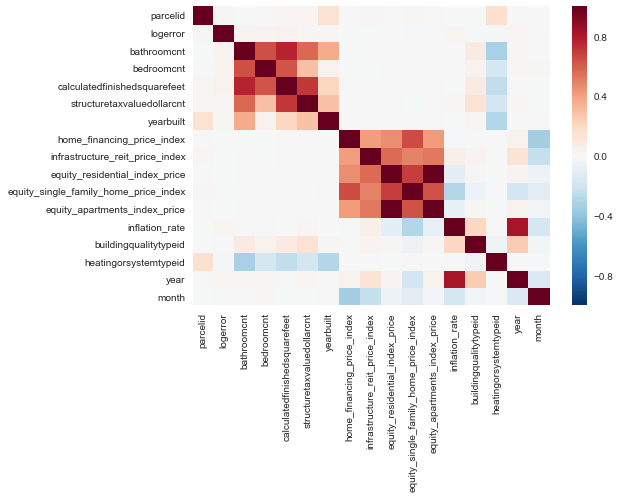

In [19]:
sns.heatmap(d.corr(), xticklabels=d.columns.values,yticklabels=d.columns.values)

In [20]:
## Testing out the missing data stats
missing_df = d.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')
missing_df

,column_name,missing_count
2,bathroomcnt,34
3,bedroomcnt,34
5,structuretaxvaluedollarcnt,529
4,calculatedfinishedsquarefeet,896
6,yearbuilt,1060
13,buildingqualitytypeid,60715
14,heatingorsystemtypeid,62237


###  Treating missing data
This data has significant missing data on some of the variables we are using. 
    - For the numeric variables, We use median imputaiton
    - For Categorical (numerical) variables we introduce a new category of no information.

In [21]:
#Creating an imputation dictionary
imputation_dict = defaultdict()
for i in numeric_variables:
    x = sum(d[i].notnull()*1)
    imputation_dict[i]=d[i].median()

In [22]:
imputation_dict

defaultdict(None,
            {'bathroomcnt': 2.0,
             'bedroomcnt': 3.0,
             'calculatedfinishedsquarefeet': 1541.0,
             'equity_apartments_index_price': 1.04,
             'equity_residential_index_price': 1.19,
             'equity_single_family_home_price_index': 0.4,
             'home_financing_price_index': 1.28,
             'inflation_rate': 1.6,
             'infrastructure_reit_price_index': 2.14,
             'structuretaxvaluedollarcnt': 134051.0,
             'yearbuilt': 1970.0})

In [23]:
d1 = d.copy()
# Imputing missing data with median values of columns
for i in numeric_variables:
    x = sum(d[i].isnull()*1)
    if x>0:
        d1[i].replace(np.nan,imputation_dict[i],inplace=True)
        print("imputation happened for: ", i," with ",imputation_dict[i])

imputation happened for:  bathroomcnt  with  2.0
imputation happened for:  bedroomcnt  with  3.0
imputation happened for:  calculatedfinishedsquarefeet  with  1541.0
imputation happened for:  structuretaxvaluedollarcnt  with  134051.0
imputation happened for:  yearbuilt  with  1970.0


### Normalization of the data set
The large property descripor variables are normalised - by scaling and mean centering.
mu_dict and sig_dict store the normalization parameters of mean and standart deviation of the columns.

In [24]:
#Normalizing The Numeric variables
# Creating dictionaries for mu and sigma
#Creating an imputation dictionary
mu_dict = defaultdict()
sig_dict = defaultdict()
for i in initial_numeric_variables:
    mu_dict[i] = d1[i].mean()
    sig_dict[i] = d1[i].std()
    d1[i]=(d1[i]-mu_dict[i])/sig_dict[i]

In [25]:
mu_dict

defaultdict(None,
            {'bathroomcnt': 2.288207018965024,
             'bedroomcnt': 3.0417302010864384,
             'calculatedfinishedsquarefeet': 1777.3620389783666,
             'structuretaxvaluedollarcnt': 184187.54495258743,
             'yearbuilt': 1968.5783438959306})

In [26]:
sig_dict

defaultdict(None,
            {'bathroomcnt': 1.00074254858147,
             'bedroomcnt': 1.1490182809458915,
             'calculatedfinishedsquarefeet': 938.0031628063293,
             'structuretaxvaluedollarcnt': 218956.47180317095,
             'yearbuilt': 23.702292031766458})

### Treating the Numeric categorical variables
- Now we do 0 imputation in NaNs in as a new numeric category.
- We also do one hot encoding on them to make sure increasing numeric values don't get interpreded as higher values.

In [29]:
categorical_variables

['buildingqualitytypeid', 'heatingorsystemtypeid', 'year', 'month']

In [30]:
## Replacing NaNs in Categorical variables with 0's
for i in categorical_variables:
    d1[i].replace(np.nan,0.0,inplace=True)

In [33]:
## One hot encoding the categorical variables
columnsToEncode = categorical_variables
# Adding dummies
for feature in columnsToEncode:
        print('One Hot Encoding: ', feature)
        d1 = pd.concat([d1, pd.get_dummies(d1[feature],prefix=feature)], axis=1)
        del d1[feature]


One Hot Encoding:  buildingqualitytypeid
One Hot Encoding:  heatingorsystemtypeid
One Hot Encoding:  year
One Hot Encoding:  month


## Training & Testing the model
- Now we have preprocessed the data to a stage where we can start building models.
- We do a 75% 25% split on the dataset, with 75% as training and 25% as test.

We train a random forest regressor

In [ ]:
## Creating a test-train split
train=d1.sample(frac=0.75,random_state=200)
test=d1.drop(train.index)

In [35]:
# Separating predictors and response variables
all_column_names = list(train.columns)
for i in ['parcelid','logerror']:
    all_column_names.remove(i)
    
# X variable names
x_vars = all_column_names
y_var = 'logerror'
# Train set
train_Y = train[y_var]
train_X = train[x_vars]
#Test set
test_Y = test[y_var]
test_X = test[x_vars]
test_key = test['parcelid']

In [37]:
# Random forest example
randreg = RandomForestRegressor(n_estimators=50,max_depth=4)
randreg.fit(train_X,train_Y)
logerror_prediction_y=randreg.predict(test_X)
# The mean squared error
print("Mean squared error: %1.5f"
      % mean_squared_error(test_Y, logerror_prediction_y))
# Explained variance score: 1 is perfect prediction
print('Variance score: %1.5f' % r2_score(test_Y, logerror_prediction_y))

Mean squared error: 0.02572
Variance score: 0.01381


###  Random Forest Results:
    - The model has a RMSE of 0.026 and a r^2 score 0.014 on the test data.
    - I had also tried the good old linear model, but r^2 score was about 5 times lower.


### Preparing the submission now for Kaggle
Here we start the process of prediction on all 3 million points

In [41]:
dpf = dfp1.copy()

In [42]:
#Save the key col
dp_key_col = dpf['parcelid'].copy()

In [43]:
# Categorical variables are Numeric here. Replace NaN's with 0.0, then hot one encode.
categorical_variables=['buildingqualitytypeid','heatingorsystemtypeid']#, 'year','month']

## Impute the NaN's in the following columns with median values
initial_numeric_variables = ['bathroomcnt','bedroomcnt','calculatedfinishedsquarefeet','structuretaxvaluedollarcnt'] + oldness_attribute
additional_numeric_variables = pricing_column_names + inflation_rate_column_names

numeric_variables = initial_numeric_variables# + additional_numeric_variables
# This is the key variable that will help with the join
key_variable = ['parcelid']
log_error_variable = ['logerror']
# Full variable list:
properties_variables =  key_variable + numeric_variables + categorical_variables

In [44]:
dp = dpf[properties_variables].copy()
dp = dp.drop('parcelid',1)

In [45]:
for i in numeric_variables:
    x = sum(dp[i].isnull()*1)
    if x>0:
        dp[i].replace(np.nan,imputation_dict[i],inplace=True)
        print("imputation happened for: ", i," with ",imputation_dict[i])

imputation happened for:  bathroomcnt  with  2.0
imputation happened for:  bedroomcnt  with  3.0
imputation happened for:  calculatedfinishedsquarefeet  with  1541.0
imputation happened for:  structuretaxvaluedollarcnt  with  134051.0
imputation happened for:  yearbuilt  with  1970.0


In [46]:
for i in initial_numeric_variables:
    x = sum(dp[i].isnull()*1)
    if x>0:
        dp[i].replace(np.nan,imputation_dict[i],inplace=True)
        print("imputation happened for: ", i," with ",imputation_dict[i])

In [47]:
#Normalizing The Numeric variables
for i in initial_numeric_variables:
    dp[i]=(dp[i]-mu_dict[i])/sig_dict[i]

In [48]:
# Checking for NaNs in categorical numeric variables
for i in categorical_variables:
    print(i, sum(dp[i].notnull()*1))

buildingqualitytypeid 1938488
heatingorsystemtypeid 1806401


In [49]:
## Replacing NaNs in Categorical variables with 0's
for i in categorical_variables:
    dp[i].replace(np.nan,0.0,inplace=True)

In [50]:
## One hot encoding the simple categorical variables
columnsToEncode = categorical_variables
# Adding dummies
for feature in columnsToEncode:
        print('One Hot Encoding: ', feature)
        dp = pd.concat([dp, pd.get_dummies(dp[feature],prefix=feature)], axis=1)
        del dp[feature]

One Hot Encoding:  buildingqualitytypeid
One Hot Encoding:  heatingorsystemtypeid


In [51]:
month_updation_list = ['month_1','month_2','month_3','month_4','month_5','month_6',
                 'month_7','month_8','month_9','month_10','month_11','month_12']
year_updation_list = ['year_2016','year_2017']

#Creating year dummy variables
for i in year_updation_list:
     dp[i]=0

#Creating month dummy variables
for i in month_updation_list:
     dp[i]=0

## Hence Generating the prediction series for 6 distince time points
-201610
-201611
-201612
-201710
-201711
-201712
I have not used any function as for last 3 cases the external data has to be approximated.
For 201710, I have used 201709, for 201711 I have used the mean of 201709 and 201708, and for 201712
I have used the mean of 201707,201708, and 201709

In [53]:
# For 201610
ext_data = indices_and_inflation_data[indices_and_inflation_data['year_month']==201610]
dq1 = dp.copy()
for i in additional_numeric_variables:
    dq1[i] = float(ext_data[i])
# Set year coordinates
for i in year_updation_list:
    dq1[i]=0
dq1['year_2016']=1

#Set month coordinates
for i in month_updation_list:
    dq1[i]=0
dq1['month_10']=1
# Run predict
print('Running prediction now...')
pred_logerr_201610 = randreg.predict(dq1[all_column_names])
print("Predict complete: Length is: ", len(pred_logerr_201610))

Running prediction now...
Predict complete: Length is:  2985217


In [54]:
# For 201611
ext_data = indices_and_inflation_data[indices_and_inflation_data['year_month']==201611]
dq2 = dp.copy()
for i in additional_numeric_variables:
    dq2[i] = float(ext_data[i])
# Set year coordinates
for i in year_updation_list:
    dq2[i]=0
dq2['year_2016']=1

#Set month coordinates
for i in month_updation_list:
    dq2[i]=0
dq2['month_11']=1
# Run predict
print('Running prediction now...')
pred_logerr_201611 = randreg.predict(dq2[all_column_names])
print("Predict complete: Length is: ", len(pred_logerr_201611))

Running prediction now...
Predict complete: Length is:  2985217


In [55]:
# For 201612
ext_data = indices_and_inflation_data[indices_and_inflation_data['year_month']==201612]
dq3 = dp.copy()
for i in additional_numeric_variables:
    dq3[i] = float(ext_data[i])
# Set year coordinates
for i in year_updation_list:
     dq3[i]=0
dq3['year_2016']=1

#Set month coordinates
for i in month_updation_list:
     dq3[i]=0
dq3['month_12']=1
# Run predict
print('Running prediction now...')
pred_logerr_201612 = randreg.predict(dq3[all_column_names])
print("Predict complete: Length is: ", len(pred_logerr_201612))

Running prediction now...
Predict complete: Length is:  2985217


In [56]:
# For 201710
ext_data = indices_and_inflation_data[indices_and_inflation_data['year_month']==201709]
dq4 = dp.copy()
for i in additional_numeric_variables:
    dq4[i] = float(ext_data[i])
# Set year coordinates
for i in year_updation_list:
    dq4[i]=0
dq4['year_2017']=1

#Set month coordinates
for i in month_updation_list:
    dq4[i]=0
dq4['month_10']=1
# Run predict
print('Running prediction now...')
pred_logerr_201710 = randreg.predict(dq4[all_column_names])
print("Predict complete: Length is: ", len(pred_logerr_201710))

Running prediction now...
Predict complete: Length is:  2985217


In [57]:
# For 201711
ext_data1 = indices_and_inflation_data[indices_and_inflation_data['year_month']==201709]
ext_data2 = indices_and_inflation_data[indices_and_inflation_data['year_month']==201708]
ext_data = ext_data1.append(ext_data2)
dq5 = dp.copy()
for i in additional_numeric_variables:
    v = ext_data[i].mean()
    print("Avg for :",i," is: ", v)
    dq5[i] = v
# Set year coordinates
for i in year_updation_list:
    dq5[i]=0
dq5['year_2017']=1

#Set month coordinates
for i in month_updation_list:
    dq5[i]=0
dq5['month_11']=1
# Run predict
print('Running prediction now...')
pred_logerr_201711 = randreg.predict(dq5[all_column_names])
print("Predict complete: Length is: ", len(pred_logerr_201711))

Avg for : home_financing_price_index  is:  0.625
Avg for : infrastructure_reit_price_index  is:  -0.17999999999999972
Avg for : equity_residential_index_price  is:  -1.5399999999999998
Avg for : equity_single_family_home_price_index  is:  -0.4700000000000001
Avg for : equity_apartments_index_price  is:  -1.6500000000000001
Avg for : inflation_rate  is:  2.05
Running prediction now...
Predict complete: Length is:  2985217


In [58]:
# For 201712
ext_data1 = indices_and_inflation_data[indices_and_inflation_data['year_month']==201709]
ext_data2 = indices_and_inflation_data[indices_and_inflation_data['year_month']==201708]
ext_data3 = indices_and_inflation_data[indices_and_inflation_data['year_month']==201707]
ext_data = ext_data1.append(ext_data2)
ext_data = ext_data.append(ext_data3)
dq6 = dp.copy()
for i in additional_numeric_variables:
    dq6[i] = float(ext_data[i].mean())
# Set year coordinates
for i in year_updation_list:
     dq6[i]=0
dq6['year_2017']=1

#Set month coordinates
for i in month_updation_list:
     dq6[i]=0
dq6['month_12']=1
# Run predict
print('Running prediction now...')
pred_logerr_201712 = randreg.predict(dq6[all_column_names])
print("Predict complete: Length is: ", len(pred_logerr_201712))

Running prediction now...
Predict complete: Length is:  2985217


In [59]:
## Adding the columns
dp['201610']=pred_logerr_201610
dp['201611']=pred_logerr_201611
dp['201612']=pred_logerr_201612
dp['201710']=pred_logerr_201710
dp['201711']=pred_logerr_201711
dp['201712']=pred_logerr_201712
dp = pd.concat([dp_key_col,dp],axis=1)

In [60]:
#Finally creating the target CSV by dropping off unnecessary columns
tdf = dp.copy()
for i in list(tdf.columns):
    if i in ['parcelid','201610','201611','201612','201710','201711','201712']:
        continue
    else:
        #print('Dropped: ',i)
        tdf=tdf.drop(i,1)

In [62]:
tdf.head(5)

,parcelid,201610,201611,201612,201710,201711,201712
0,10754147,0.009936,0.010365,0.010365,0.010365,0.010365,0.010365
1,10759547,0.009936,0.010365,0.010365,0.010365,0.010365,0.010365
2,10843547,0.092123,0.096612,0.090565,0.096612,0.092123,0.092123
3,10859147,0.032521,0.035262,0.033330,0.035718,0.032776,0.033330
4,10879947,0.006694,0.007351,0.007351,0.007351,0.007351,0.007351


In [61]:
tdf.to_csv("c:/Users/ibipul/Documents/Python Scripts/datasets/zillow_data/prepd_submission_file_1015.csv",index=False)

# Task 6. Permutation Test

In [165]:
from sklearn.metrics import mean_absolute_error
import sklearn.utils

### Following are the functions we set up to run permutations test
What fraction of permutations produce at least error at least as good at the real data set?

In [184]:
# This function returns the mean absolute deviation of a random shuffle of test_y against the predicted value
def score_a_shuffle(shuffle_y, pred_y):
    return mean_absolute_error(shuffle_y, pred_y)

# Function to compare score 
def compare_score(shuffle_score, original):
    return(sum((shuffle_score < original)*1)/len(shuffle_score))

#Function to run the permutation test           
def permutation_test(test_Y, logerror_prediction_y,n_count=100):
    score_list = []
    for i in range(n_count):
        s = score_a_shuffle(sklearn.utils.shuffle(test_Y),logerror_prediction_y)
        score_list.append(s)
    return score_list

For the original test set used in Task no. 5, we have a set of ~ 42k points 
on which we ran predict to report model performance. That set is now our bench mark,
against which we are going to run our permutation test.

In [172]:
# Use the original test_Y and predicted value of Y to get the baseline score
original_score = score_a_shuffle(test_Y,logerror_prediction_y)
original_score

0.068695364578740647

In [181]:
# Now we run 1000 permutations on the test_Y of the test data
# and compute mean absolute deviation against the baseline logerror_prediction_y that the model gave out.
scores = permutation_test(test_Y,logerror_prediction_y, n_count= 1000)

In [185]:
# Here we take the list of score generated in the permutation test
# and the original mean absolute_deviation/score for out model
compare_score(scores, original_score)

0.0

### Result of permutation test score
-In the 42k test set data points, I established the baseline score (M.a.d) at 0.068 using the original log error and predicted log error.
- Then I started running random shuffle/permutations of the 42k log errors and computed m.a.d score with the original log_error_prediction each time.
- The thousand scores thus obtained are then compared against the baseline. 
- 0% of the time the scores were better than the model that has been build

### Now we obtain p-value of prediction


In [190]:
from sklearn.cross_validation import permutation_test_score

In [ ]:
# Sampled predictor and response data
train_x = train_X[1:10000]
train_y = train_Y[1:10000]
score, pscore, pvalue = permutation_test_score(randreg, train_x, train_y, n_permutations=100)
print(" Permutation Score is %s with p-value of %s", pscore, pvalue)

In [194]:
len(test_X.columns)

51